<a href="https://colab.research.google.com/github/CoGian/NLP-with-Disaster-Tweets/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import random
import pickle 
import gc
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys

In [0]:
BATCH_SIZE = 32
MAX_LEN = 30 
EPOCHS = 100
NUM_MODELS = 4

In [0]:
TARGET_COLUMN = 'target'
LOCATION_COLUMN = 'location'
KEYWORD_COLUMN = 'keyword'
METADADATA_COLUMNS = [LOCATION_COLUMN] + [KEYWORD_COLUMN]
TEXT = 'text'

TRAIN_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/train_cleared.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/test_cleared.csv'
TEST_DATASET_Y_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/perfect-score.csv'
GLOVE_PATH = "/content/drive/My Drive/Glove/glove.840B.300d.pkl"
CRAWL_PATH = "/content/drive/My Drive/Crawl/crawl-300d-2M.pkl"

In [0]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df =  pd.read_csv(TEST_DATASET_PATH)
y_test_df = pd.read_csv(TEST_DATASET_Y_PATH)

In [0]:
train_df , val_df = train_test_split(train_df,test_size = 0.15,random_state = 13)

# Prepare Data for training

## Split Dataset

In [0]:
x_train = train_df[TEXT].astype(str)
y_train = train_df[TARGET_COLUMN].astype(int).values

x_val = val_df[TEXT].astype(str)
y_val = val_df[TARGET_COLUMN].astype(int).values

x_test = test_df[TEXT].astype(str)
y_test = y_test_df[TARGET_COLUMN].astype(int).values

## Create and Pad Sequences

In [0]:
#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_val) + list(x_test) )

In [0]:
#convert text data to numerical indexes
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)


#pad data up to MAX_LEN (note that we truncate if there are more than MAX_LEN tokens)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=MAX_LEN)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)

## Feed train set to tf.Dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,{"target": y_train}))
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)

## Feed validation set to tf.Dataset

In [0]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val,{"target": y_val}))
validation_dataset = validation_dataset.shuffle(len(val_df)).batch(BATCH_SIZE)

## Feed test set to tf.Dataset

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,{"target": y_test}))
test_dataset = test_dataset.shuffle(len(test_df)).batch(BATCH_SIZE)

## Build embeddings matrix

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        embedding_index = pickle.load(f)
    return embedding_index

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words 

In [14]:
glove_embedding_matrix,unknown_words = build_matrix(tokenizer.word_index,GLOVE_PATH)
print('n unknown words (glove): ', len(unknown_words))
print('n known words (glove): ', len(glove_embedding_matrix))

n unknown words (glove):  5634
n known words (glove):  27282


In [15]:
crawl_embedding_matrix,unknown_words = build_matrix(tokenizer.word_index,CRAWL_PATH)
print('n unknown words (crawl): ', len(unknown_words))
print('n known words (crawl): ', len(crawl_embedding_matrix))

n unknown words (crawl):  5689
n known words (crawl):  27282


In [16]:
embedding_matrix = np.concatenate([glove_embedding_matrix, crawl_embedding_matrix], axis=-1)
embedding_matrix.shape

(27282, 600)

In [17]:
del crawl_embedding_matrix
del glove_embedding_matrix
gc.collect()

0

# Build Model 

In [0]:
def RNN(embedding_matrix):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.2,return_sequences=True))(x)
  x = tf.keras.layers.Dense(8,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.8)(x)

  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target' )(x)
    
  model = tf.keras.Model(inputs=words, outputs=[result])
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  return model

In [0]:
def simple(embedding_matrix):
   words = tf.keras.Input(shape=(None,))
   x = tf.keras.layers.Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
   x = tf.keras.layers.Dense(64,activation='relu')(x)
   x = tf.keras.layers.Dense(32,activation='relu')(x)
   x = tf.keras.layers.Dropout(0.5)(x)
   
   result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target' )(x)
   
   model = tf.keras.Model(inputs=words, outputs=[result])
   model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
   return model

# Fit the model 

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15 , restore_best_weights=True , verbose=1)
model = RNN(embedding_matrix)
history = model.fit(x = train_dataset,validation_data=validation_dataset , callbacks=[callback] , epochs = EPOCHS )

Epoch 1/100
203/203 [==============================] - 5s 24ms/step - loss: 0.5997 - accuracy: 0.7011 - val_loss: 0.4805 - val_accuracy: 0.8102
Epoch 2/100
203/203 [==============================] - 4s 20ms/step - loss: 0.5365 - accuracy: 0.7558 - val_loss: 0.4420 - val_accuracy: 0.8100
Epoch 3/100
203/203 [==============================] - 4s 22ms/step - loss: 0.5144 - accuracy: 0.7660 - val_loss: 0.4364 - val_accuracy: 0.8177
Epoch 4/100
203/203 [==============================] - 4s 19ms/step - loss: 0.4962 - accuracy: 0.7727 - val_loss: 0.4330 - val_accuracy: 0.8117
Epoch 5/100
203/203 [==============================] - 4s 19ms/step - loss: 0.4795 - accuracy: 0.7799 - val_loss: 0.4477 - val_accuracy: 0.8209
Epoch 6/100
203/203 [==============================] - 4s 21ms/step - loss: 0.4650 - accuracy: 0.7869 - val_loss: 0.4277 - val_accuracy: 0.8159
Epoch 7/100
203/203 [==============================] - 4s 20ms/step - loss: 0.4529 - accuracy: 0.7910 - val_loss: 0.4536 - val_accuracy:

In [26]:
model.evaluate(x= test_dataset)

102/102 [==============================] - 1s 9ms/step - loss: 0.4386 - accuracy: 0.8130


[0.4386068880558014, 0.8130043148994446]

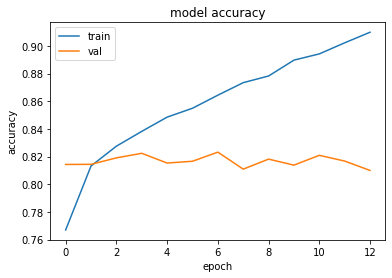

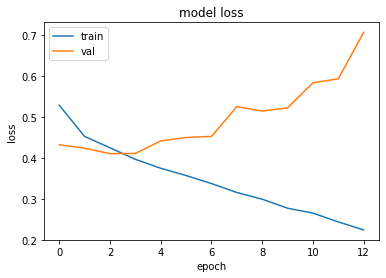

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.save_weights('/content/drive/My Drive/NLP with Disaster Tweets/data/checkpoints/my_checkpoint')